## This is the data cleaning operations we did for the kc housing bake off

##### Import all of the packages

In [1]:
import matplotlib.pyplot as plt
from math import exp
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
df_kc = pd.read_csv('kc_house_data_train.csv')

##### Imputing data

In [1]:
def kc_cleaning_pipeline(dataframefile):
    
    '''
    Function pipeline to process pandas dataframe of Kings county housing data for multiple linear regression modeling.
    
    =========
    Arguments: filepath of unprocessed data as a string.
    =========
    
    =======
    Returns: processed dataframe in preparation for multiple linear regression
    =======
    '''
   

    df_kc = pd.read_csv(dataframefile)
    
    ################################################################ DATA FORMATTING/CLEANING ################################################################
    
    rnmdate = {'date':'selldate'}
    df_kc.rename(columns = rnmdate, inplace = True)
    
    df_kc.selldate = df_kc.selldate.apply(lambda x: x[:8])
    df_kc.selldate = df_kc.selldate.apply(lambda x: pd.to_datetime(x, yearfirst=True, format='%Y%m%d'))
    
    df_kc['yr_old'] = np.where(df_kc['yr_renovated'] != 0, df_kc['selldate'].apply(lambda x: x.year) - df_kc['yr_renovated'], 
                       df_kc['selldate'].apply(lambda x: x.year) - df_kc['yr_built'])

    df_kc['yr_old'] = np.where(df_kc['yr_old'] < 0, 0, df_kc['yr_old'])
    
    # turning the 0s into nans 
    df_kc.yr_renovated = np.where(df_kc.yr_renovated == 0, np.nan, df_kc.yr_renovated)

    # make a column that has the sqft living / sqft lot. Effectively, how big is the house in comparison to the land

    df_kc['liv_lot_ratio'] = df_kc.sqft_living / df_kc.sqft_lot 



    

    # The below np.select function is to adjust all of the houses estimation of number of bathrooms 

   
    conditions = [  (df_kc.sqft_living <= 3000) & ((df_kc.bathrooms >= 0) & (df_kc.bathrooms <= 1.5)),
                    ((df_kc.sqft_living  <= 3800) & (df_kc.sqft_living  >= 3000))  & ((df_kc.bathrooms >= 0) & (df_kc.bathrooms <= 3)), 
                    ((df_kc.sqft_living  <= 4800) & (df_kc.sqft_living  > 3800))  & ((df_kc.bathrooms >= 0) & (df_kc.bathrooms <= 2)),
                   (df_kc.liv_lot_ratio <= 0.001)]

    choices = [ df_kc.bathrooms,
                df_kc.bathrooms.median(),
                df_kc.bedrooms,
                df_kc.bathrooms]

    df_kc.bathrooms = np.select(conditions, choices, default = df_kc.bathrooms)

   




    #The below np.select() function is to adjust all of the houses with an overestimation of bedrooms

    
    df_kc.at[8597, 'bedrooms'] = 3

    conditions = [ (df_kc.sqft_living <= 3000) & ((df_kc.bedrooms >= 1) & (df_kc.bedrooms <= 7)), # do the smaller end
                    (df_kc.sqft_living  > 4000) & ((df_kc.bedrooms >= 1) & (df_kc.bedrooms <= 3)) # do the upper end
                   ]

    choices = [ df_kc.bedrooms.mean(),
               5
                ]

    df_kc.bedrooms = np.select(conditions, choices, default = df_kc.bedrooms)


    
    
    
    
    # The below np.select() function is to adjust all of the houses with an underestimation of bedrooms
    
    conditions = [  (df_kc.sqft_living > 3000) & ((df_kc.bedrooms >= 0) & (df_kc.bedrooms <= 3)), # do the upper end
                    ((df_kc.sqft_living  <= 3800) & (df_kc.sqft_living  > 2800))  & ((df_kc.bedrooms >= 0) & (df_kc.bedrooms <= 3)) # do the lower end
                   ]

    choices = [ 6.5,
                4.5
                ]

    df_kc.bedrooms = np.select(conditions, choices, default = df_kc.bedrooms)
    
    
    
    ################################################################ FEATURE ENGINEERING  ################################################################
    

    # bedrooms to bathrooms ratio
    df_kc['bed_bath'] = df_kc['bedrooms']/df_kc['bathrooms']
                
   
    ### Create feature for housing listing proximity to nearest central transit center (sites that host major rail and bus lines) .
    #transit_loc = {'Northgate TC': (47.707696,-122.326842),
    #           'UW': (47.651572,-122.304242) ,
    #           'Westlake': (47.612982,-122.336532) ,
    #           'Capitol Hill': (47.621353,-122.320111) ,
    #           'Bellevue': (47.617540,-122.-195230),
    #           'Pine Street, 9th ave': (47.614489,-122.332074) ,
    #           'Pioneer Square': (47.603276,-122.331904) ,
    #           'Kings Street': (47.598833,-122.329926) ,
    #           "Int'l District/ctown": (47.598308,-122.327837) ,
    #           '6th ave S & S Atlantic': (47.591008,-122.325878) ,
    #           'Rainier Ave & Mt Baker TC': (47.578748,-122.297142) ,
    #           'Rainier Beach': (47.524828,-122.280494),
    #           'Columbia City': (47.560558,-122.293057) ,
    #           'Kings County South Base': (47.499379,-122.284285) ,
    #           'Tukwila': (47.463233,-122.238660) ,
    #           'Renton TC': (47.488332,-122.210975),
    #           'Burien TC': (47.474578,-122.334315)}
    #
    #loc_coord = np.array(list(zip(df_kc.lat, df_kc.long)))
    #
    #import geopy.distance
    #metro_prox = []
    #for houseloc in loc_coord:
    #    sortlist=[]
    #    for transitloc in transit_loc.values():
    #        sortlist.append(geopy.distance.great_circle(houseloc,transitloc).miles)
    #        #print(len(sortlist))
    #    metro_prox.append(min(sortlist))
    #    
    #df_kc['metro_prox'] = metro_prox
    
    
    ### Create zip code grouping dummies.
    
    #zips = df_kc.groupby('zipcode').price.mean().sort_values(ascending = True)
    #
    #df_kc2 = zips.to_frame().reset_index()
    #
    #ziplist = []
    #sublist = []
    #for i in range(69):
    #    if len(sublist) == 0:
    #        sublist = [df_kc2.zipcode.iloc[i]]
    #        if df_kc2.price.iloc[i+1]/df_kc2.price.iloc[i] < 1.02:
    #            sublist.append(df_kc2.zipcode.iloc[i+1])
    #        else:
    #            ziplist.append(sublist)
    #            sublist = []
    #    else:
    #        if df_kc2.price.iloc[i+1]/df_kc2.price.iloc[i] < 1.02:
    #            sublist.append(df_kc2.zipcode.iloc[i+1])
    #        else:
    #            ziplist.append(sublist)
    #            sublist = []
    #ziplist.append([df_kc2.zipcode.iloc[69]])
   #
    #zipstr = [str(x) for x in ziplist]
    #zipdict = dict(zip(zipstr, ziplist))
    #
    #zipunique = df_kc.zipcode.unique().tolist()
    #ziplist1 = []
    #
    #for i in zipunique: 
    #    for j, k in zipdict.items():
    #        if i in k:
    #            ziplist1.append(j)
    #            
    #zipdict1 = dict(zip(zipunique, ziplist1))
    #df_kc['zipgroup'] = df_kc['zipcode'].map(zipdict1)
    #
    #df_kc = pd.concat([df_kc, pd.get_dummies(df_kc['zipgroup'])], 1)
    
    return df_kc
    
    
    

In [5]:

# turning the 0s into nans 
#df_kc.yr_renovated = np.where(df_kc.yr_renovated == 0, np.nan, df_kc.yr_renovated)

## make a column that has the sqft living / sqft lot. Effectively, how big is the house in comparison to the land
#
#df_kc['liv_lot_ratio'] = df_kc.sqft_living / df_kc.sqft_lot 
#
#
#
#""" 
#The below np.select function is to adjust all of the houses estimation of number of bathrooms 
#
#"""
#
#
#conditions = [ ((df_kc.price <= 650000)) & (df_kc.sqft_living <= 3000) & ((df_kc.bathrooms >= 0) & (df_kc.bathrooms <= 1.5)),
#               ((df_kc.price  > 650000) & (df_kc.price <= 850000)) & ((df_kc.sqft_living  <= 3800) & (df_kc.sqft_living  >= 3000))  & ((df_kc.bathrooms >= 0) & (df_kc.bathrooms <= 3)), 
#               ((df_kc.price  > 850000) & (df_kc.price < 1250000)) & ((df_kc.sqft_living  <= 4800) & (df_kc.sqft_living  > 3800))  & ((df_kc.bathrooms >= 0) & (df_kc.bathrooms <= 2)),
#               (df_kc.liv_lot_ratio <= 0.001)]
#
#choices = [ df_kc.bathrooms,
#            df_kc.bathrooms.median(),
#            df_kc.bedrooms,
#            df_kc.bathrooms]
#
#df_kc.bathrooms = np.select(conditions, choices, default = df_kc.bathrooms)
#
#"""
#The below np.select() function is to adjust all of the houses with an overestimation of bedrooms
#"""
#
#
#df_kc.at[8597, 'bedrooms'] = 3
#
#conditions = [ (df_kc.price <= 650000) & (df_kc.sqft_living <= 3000) & ((df_kc.bedrooms >= 1) & (df_kc.bedrooms <= 7)), # do the smaller end
#               ((df_kc.price  > 700000) & (df_kc.price < 1000000) & (df_kc.sqft_living  > 4000)) & ((df_kc.bedrooms >= 1) & (df_kc.bedrooms <= 3)) # do the upper end
#               ]
#
#choices = [ df_kc.bedrooms.mean(),
#            5
#            ]
#
#df_kc.bedrooms = np.select(conditions, choices, default = df_kc.bedrooms)
#
#
#"""
#The below np.select() function is to adjust all of the houses with an underestimation of bedrooms
#"""
#conditions = [ ((df_kc.price > 850000)) & (df_kc.sqft_living > 3000) & ((df_kc.bedrooms >= 0) & (df_kc.bedrooms <= 3)), # do the upper end
#               ((df_kc.price  > 700000) & (df_kc.price < 850000)) & ((df_kc.sqft_living  <= 3800) & (df_kc.sqft_living  > 2800))  & ((df_kc.bedrooms >= 0) & (df_kc.bedrooms <= 3)) # do the lower end
#               ]
#
#choices = [ 6.5,
#            4.5
#            ]
#
#df_kc.bedrooms = np.select(conditions, choices, default = df_kc.bedrooms)
#
## this gives us a living to lot size ratio
#df_kc['price_sqft_liv'] = df_kc['price']/df_kc['sqft_living'] 
#
# # bedrooms to bathrooms ratio
#df_kc['bed_bath'] = df_kc['bedrooms']/df_kc['bathrooms']

### feature engineering

# this gives us a living to lot size ratio
#df_kc['price_sqft_liv'] = df_kc['price']/df_kc['sqft_living'] 

 # bedrooms to bathrooms ratio
#df_kc['bed_bath'] = df_kc['bedrooms']/df_kc['bathrooms']

kc_df[features]

In [11]:
kc_df = kc_cleaning_pipeline('kc_house_data_train.csv')

In [12]:
zipdict1

NameError: name 'zipdict1' is not defined

In [111]:
kc_df.head()

,Unnamed: 0,id,selldate,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_old,liv_lot_ratio,price_sqft_liv,bed_bath,metro_prox,zipgroup,[98001],[98002],[98004],[98006],"[98008, 98052, 98177]","[98011, 98059, 98070]",[98014],"[98028, 98125, 98166]",[98032],"[98034, 98065]",[98039],[98040],"[98058, 98108]",[98074],"[98077, 98053]",[98092],[98102],"[98105, 98119, 98109]","[98107, 98103, 98024, 98007, 98027, 98115, 98116, 98029, 98122, 98144]",[98112],[98118],[98133],"[98136, 98072, 98117]","[98146, 98038]",[98148],"[98155, 98056, 98010, 98126, 98019, 98045]",[98168],"[98188, 98023, 98003, 98030, 98031, 98198, 98055, 98022, 98042, 98178, 98106]","[98199, 98075, 98033, 98005]"
0,0,2591820310,2014-10-06,365000.0,3.370735,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,NaN,98058,47.4388,-122.162,2390,7700,28,0.232767,176.328502,1.498104,3.959637,"[98058, 98108]",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7974200820,2014-08-21,865000.0,5.000000,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,NaN,98115,47.6784,-122.285,2370,6283,37,0.430906,298.275862,1.666667,2.058557,"[98107, 98103, 98024, 98007, 98027, 98115, 981...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,7701450110,2014-08-15,1038000.0,4.000000,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,NaN,98006,47.5646,-122.129,3710,9685,17,0.346094,275.331565,1.600000,6.511235,[98006],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,9522300010,2015-03-31,1490000.0,6.500000,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,NaN,98034,47.6995,-122.228,4050,14226,25,0.312158,326.754386,1.857143,4.630665,"[98034, 98065]",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,9510861140,2014-07-14,711000.0,3.000000,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,NaN,98052,47.6647,-122.083,2250,4050,10,0.474330,278.823529,1.200000,10.336048,"[98008, 98052, 98177]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
kc_df.columns

Index(['Unnamed: 0', 'id', 'selldate', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_old',
       'liv_lot_ratio', 'bed_bath', 'zipgroup', '[98001]', '[98002]',
       '[98004]', '[98006]', '[98008, 98052, 98177]', '[98011, 98059, 98070]',
       '[98014]', '[98028, 98125, 98166]', '[98032]', '[98034, 98065]',
       '[98039]', '[98040]', '[98058, 98108]', '[98074]', '[98077, 98053]',
       '[98092]', '[98102]', '[98105, 98119, 98109]',
       '[98107, 98103, 98024, 98007, 98027, 98115, 98116, 98029, 98122, 98144]',
       '[98112]', '[98118]', '[98133]', '[98136, 98072, 98117]',
       '[98146, 98038]', '[98148]',
       '[98155, 98056, 98010, 98126, 98019, 98045]', '[98168]',
       '[98188, 98023, 98003, 98030, 98031, 98198, 98055, 98022, 98042, 98178, 98106]',
       '[98199

In [5]:
features = ['bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'yr_built', 'yr_old',
       'sqft_living15', 'sqft_lot15',
       'liv_lot_ratio','[98001]', '[98002]', '[98004]', '[98006]', '[98008, 98052, 98177]',
       '[98011, 98059, 98070]', '[98014]', '[98028, 98125, 98166]', '[98032]',
       '[98034, 98065]', '[98039]', '[98040]', '[98058, 98108]', '[98074]',
       '[98077, 98053]', '[98092]', '[98102]', '[98105, 98119, 98109]',
       '[98107, 98103, 98024, 98007, 98027, 98115, 98116, 98029, 98122, 98144]',
       '[98112]', '[98118]', '[98133]', '[98136, 98072, 98117]',
       '[98146, 98038]', '[98148]',
       '[98155, 98056, 98010, 98126, 98019, 98045]', '[98168]',
       '[98188, 98023, 98003, 98030, 98031, 98198, 98055, 98022, 98042, 98178, 98106]',
       '[98199, 98075, 98033, 98005]']
kc_df_features = kc_df[features]
target = kc_df.price

In [6]:
X_train, X_test, y_train, y_test = train_test_split(kc_df_features, target, random_state=34, test_size=0.2)
#check the shape of the results
print("Training set- Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set- Features:  (13832, 44) Target:  (13832,)
Training set - Features:  (3458, 44) Target:  (3458,)


In [7]:
# fit a model only to training set
#instantiate a linear regression object
lm = LinearRegression()
#fit the linear regression to the data
lm = lm.fit(X_train, y_train)
print(lm.intercept_)
print(lm.coef_)

2890742.6541817477
[ 3.94231103e+03  2.13255228e+04  1.28698958e+02  1.96563243e-01
 -2.43129573e+04  6.28267367e+05  5.82854730e+04  1.58531402e+04
  6.89698482e+04  5.66198659e+01 -1.64401955e+03 -1.83016749e+02
 -1.66750772e+01 -2.71736860e-01  4.08539020e+03 -2.39775633e+05
 -2.24043107e+05  5.83866056e+05  2.96576288e+04 -1.83938866e+04
 -1.51733949e+05 -1.13866574e+05 -1.21156674e+05 -2.45609864e+05
 -7.48920884e+04  1.05935633e+06  2.80890400e+05 -1.90125609e+05
 -5.59913478e+04 -4.27038192e+04 -2.69324231e+05  2.69286081e+05
  1.94550671e+05  2.15292712e+04  3.39411306e+05 -9.22257979e+04
 -9.17755039e+04  1.25058674e+03 -1.79065240e+05 -1.90282384e+05
 -1.20331591e+05 -1.86253874e+05 -2.29759000e+05  5.75118367e+04]


In [8]:
print ("R^2 Score:", lm.score(X_train, y_train))

R^2 Score: 0.8984601234516726


In [9]:
y_train_pred = lm.predict(X_train) 
y_train_pred

array([379589.99794073, 339004.71267529, 259553.40935984, ...,
       403893.57512924, 847991.95991678, 220236.74461767])

In [10]:
from sklearn import metrics

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 66056.9464683243
Mean Squared Error: 14060032807.847347
Root Mean Squared Error: 118575.00920450037


In [11]:
price_std = target.std()

print('Z-Score of Mean Absolute Error:', train_mae/price_std )
print('Z-Score of Root Mean Squared Error:' , train_rmse/price_std)

Z-Score of Mean Absolute Error: 0.17694505296685595
Z-Score of Root Mean Squared Error: 0.3176238443642972


In [12]:
y_pred = lm.predict(X_test)

Text(0, 0.5, 'Predictions')

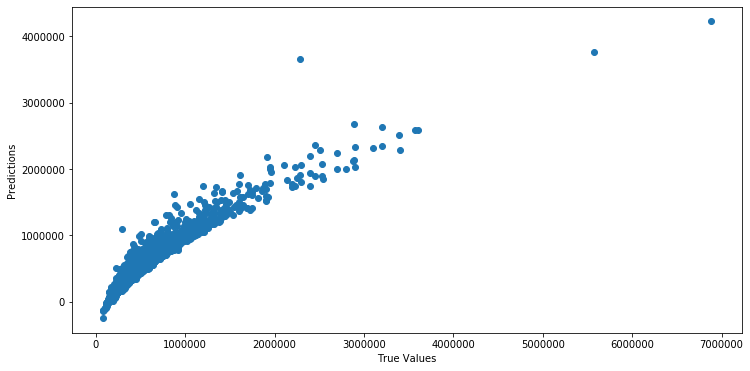

In [13]:
## The line / model
plt.figure(figsize = (12,6))
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

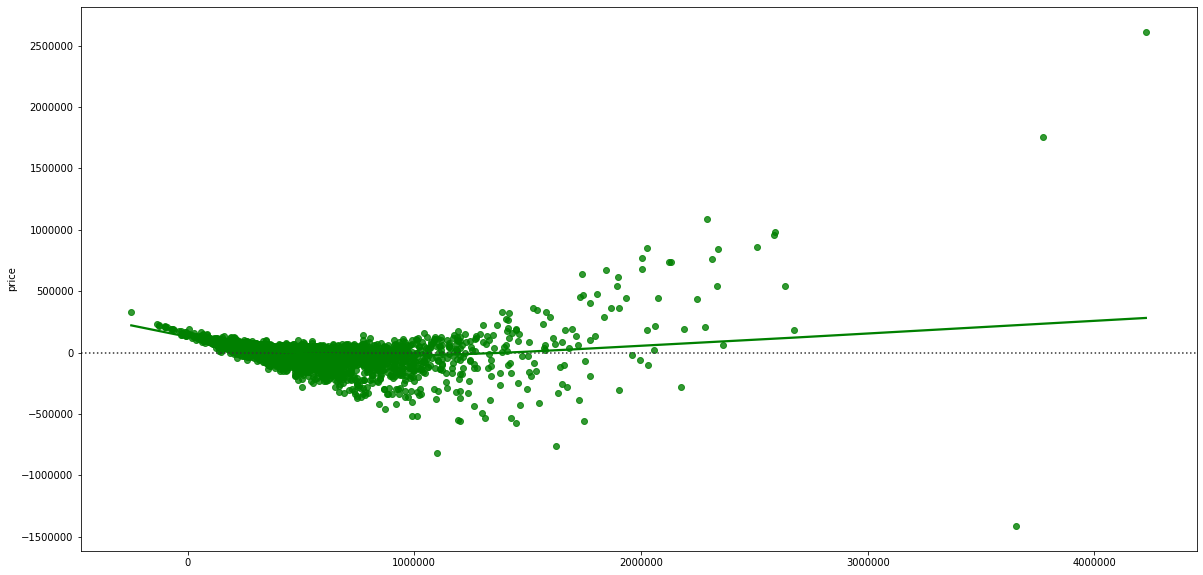

In [154]:
plt.figure(figsize=(20,10))
sns.residplot(y_pred, y_test, lowess=True, color="g")

In [14]:
print ("Score:", lm.score(X_test, y_test))

Score: 0.8920594005867136


In [15]:
test_mae = metrics.mean_absolute_error(y_test, y_pred)
test_mse = metrics.mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Mean Absolute Error:' + str(metrics.mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error:' + str(metrics.mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error:' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Mean Absolute Error:67307.70250911615
Mean Squared Error:15426686937.062618
Root Mean Squared Error:124204.2146509635


In [16]:
print('Mean Absolute Error  Z:', test_mae/price_std )
print('Root Mean Squared Error Z:' , test_rmse/price_std)

Mean Absolute Error  Z: 0.1802954211827506
Root Mean Squared Error Z: 0.33270265301560786


In [17]:
print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  118575 vs. Testing:  124204


## Try model with metro proximities and without lat/long

In [18]:
kc_df.columns

Index(['Unnamed: 0', 'id', 'selldate', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_old',
       'liv_lot_ratio', 'price_sqft_liv', 'bed_bath', 'metro_prox', 'zipgroup',
       '[98001]', '[98002]', '[98004]', '[98006]', '[98008, 98052, 98177]',
       '[98011, 98059, 98070]', '[98014]', '[98028, 98125, 98166]', '[98032]',
       '[98034, 98065]', '[98039]', '[98040]', '[98058, 98108]', '[98074]',
       '[98077, 98053]', '[98092]', '[98102]', '[98105, 98119, 98109]',
       '[98107, 98103, 98024, 98007, 98027, 98115, 98116, 98029, 98122, 98144]',
       '[98112]', '[98118]', '[98133]', '[98136, 98072, 98117]',
       '[98146, 98038]', '[98148]',
       '[98155, 98056, 98010, 98126, 98019, 98045]', '[98168]',
       '[98188, 98023, 98003, 98030, 98031, 98198, 98055, 98022, 98042

In [19]:
features = ['bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'yr_built', 'yr_old', 'sqft_living15', 'sqft_lot15',
       'liv_lot_ratio', 'price_sqft_liv', 'metro_prox','[98001]', '[98002]', '[98004]', '[98006]', '[98008, 98052, 98177]',
       '[98011, 98059, 98070]', '[98014]', '[98028, 98125, 98166]', '[98032]',
       '[98034, 98065]', '[98039]', '[98040]', '[98058, 98108]', '[98074]',
       '[98077, 98053]', '[98092]', '[98102]', '[98105, 98119, 98109]',
       '[98107, 98103, 98024, 98007, 98027, 98115, 98116, 98029, 98122, 98144]',
       '[98112]', '[98118]', '[98133]', '[98136, 98072, 98117]',
       '[98146, 98038]', '[98148]',
       '[98155, 98056, 98010, 98126, 98019, 98045]', '[98168]',
       '[98188, 98023, 98003, 98030, 98031, 98198, 98055, 98022, 98042, 98178, 98106]',
       '[98199, 98075, 98033, 98005]']
kc_df_features = kc_df[features]
target = kc_df.price

In [20]:
kc_df_features.columns, len(kc_df_features.columns)

(Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
        'yr_old', 'sqft_living15', 'sqft_lot15', 'liv_lot_ratio',
        'price_sqft_liv', 'metro_prox', '[98001]', '[98002]', '[98004]',
        '[98006]', '[98008, 98052, 98177]', '[98011, 98059, 98070]', '[98014]',
        '[98028, 98125, 98166]', '[98032]', '[98034, 98065]', '[98039]',
        '[98040]', '[98058, 98108]', '[98074]', '[98077, 98053]', '[98092]',
        '[98102]', '[98105, 98119, 98109]',
        '[98107, 98103, 98024, 98007, 98027, 98115, 98116, 98029, 98122, 98144]',
        '[98112]', '[98118]', '[98133]', '[98136, 98072, 98117]',
        '[98146, 98038]', '[98148]',
        '[98155, 98056, 98010, 98126, 98019, 98045]', '[98168]',
        '[98188, 98023, 98003, 98030, 98031, 98198, 98055, 98022, 98042, 98178, 98106]',
        '[98199, 98075, 98033, 98005]'],
       dtype='object'),
 46)

In [21]:
X1_train, X1_test, y1_train, y1_test = train_test_split(kc_df_features, target, random_state=34, test_size=0.2)
#check the shape of the results
print("Training set - Features: ", X1_train.shape, "Target: ", y1_train.shape)
print("Training set - Features: ", X1_test.shape, "Target: ",y1_test.shape)

Training set - Features:  (13832, 46) Target:  (13832,)
Training set - Features:  (3458, 46) Target:  (3458,)


In [22]:
# fit a model only to training set
#instantiate a linear regression object
lm1 = LinearRegression()
#fit the linear regression to the data
lm1 = lm1.fit(X1_train, y1_train)
print(lm1.intercept_)
print(lm1.coef_)



-795.728421897511
[ 8.74202759e+03  1.33204965e+04  2.73631864e+02 -8.37871672e-02
 -1.05646382e+04  2.87343615e+05  1.57467315e+04  7.13617331e+03
  1.99948689e+04  1.08258891e+01 -3.38110499e+02 -1.93934315e+02
 -3.05649009e+01 -8.66171124e-02 -3.68906557e+03  1.89877893e+03
 -4.56100424e+02 -1.84587279e+04  1.32973907e+04  1.61506626e+05
 -2.10380942e+04 -3.64968251e+04 -6.45038547e+04 -2.06974981e+04
 -5.11579122e+04 -1.37785651e+04 -3.50868393e+04  4.51518137e+05
  7.07414283e+04 -3.86754845e+04 -5.31270597e+04 -5.20567141e+04
 -5.34775481e+04  3.13113430e+04 -2.29636965e+04 -5.75392690e+04
  5.51910780e+04 -4.05929489e+04 -3.06874379e+04 -6.89120737e+04
 -3.34878405e+04  8.78634560e+03 -3.87933145e+04  2.46980554e+04
 -2.90934691e+04 -3.64252314e+04]


In [23]:
print ("R^2 Score:", lm1.score(X1_train, y1_train))

R^2 Score: 0.8984770734422796


In [24]:
y1_train_pred = lm1.predict(X1_train) 
y1_train_pred

array([379528.81300984, 337863.44849859, 260505.29197204, ...,
       404085.67872445, 847122.3364394 , 221461.45136286])

In [25]:
train_mae1 = metrics.mean_absolute_error(y1_train, y1_train_pred)
train_mse1 = metrics.mean_squared_error(y1_train, y1_train_pred)
train_rmse1 = np.sqrt(metrics.mean_squared_error(y1_train, y1_train_pred))


print('Mean Absolute Error:', train_mae1 )
print('Mean Squared Error:',  train_mse1)
print('Root Mean Squared Error:' , train_rmse1)

Mean Absolute Error: 66063.4712184982
Mean Squared Error: 14057685775.015236
Root Mean Squared Error: 118565.11196391305


In [26]:
price_std = target.std()

print('Z-Score of Mean Absolute Error:', train_mae1/price_std )
print('Z-Score of Root Mean Squared Error:' , train_rmse1/price_std)

Z-Score of Mean Absolute Error: 0.17696253064826334
Z-Score of Root Mean Squared Error: 0.3175973328790776


In [27]:
y1_pred = lm1.predict(X1_test)

Text(0, 0.5, 'Predictions')

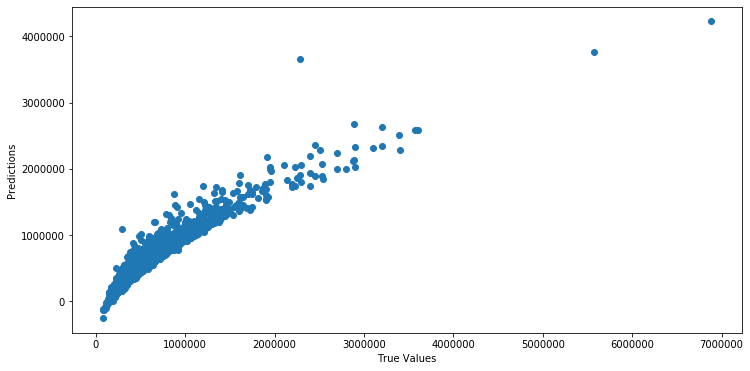

In [28]:
## The line / model
plt.figure(figsize = (12,6))
plt.scatter(y1_test, y1_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

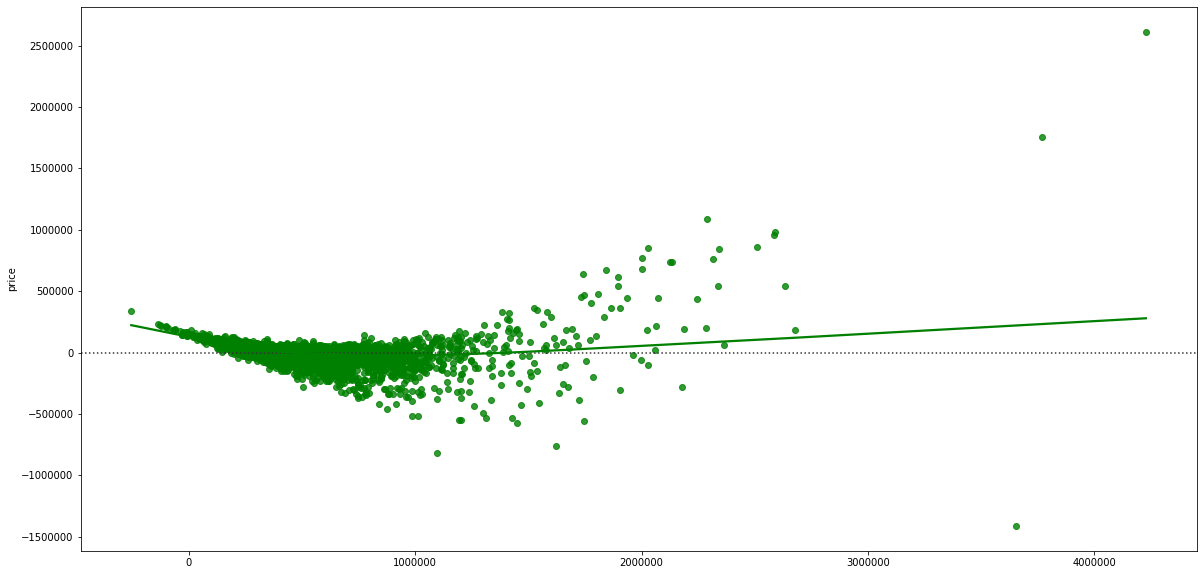

In [29]:
plt.figure(figsize=(20,10))
sns.residplot(y1_pred, y1_test, lowess=True, color="g")

In [33]:
print ("Score:", lm1.score(X1_test, y1_test))

Score: 0.8920636507446248


In [8]:
import pickle
filename = './savedModels/final_kc_lrm_v1.sav'
pickle.dump(lm, open(filename, 'wb'))

### Try $2^{nd}$ order polynomial

In [180]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)

In [181]:
poly_data = poly.fit_transform(kc_df_features)
poly_data

array([[3.37073453e+00, 2.25000000e+00, 2.07000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 3.00000000e+00, 2.90000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.00000000e+00, 2.50000000e+00, 3.77000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.37073453e+00, 1.00000000e+00, 1.05000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.37073453e+00, 1.50000000e+00, 1.90000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.37073453e+00, 1.50000000e+00, 1.33000000e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [182]:
poly_columns = poly.get_feature_names(kc_df_features.columns)
len(poly_columns)

18423

In [183]:
df_kc_poly2 = pd.DataFrame(poly_data, columns=poly_columns) 

In [184]:
df_kc_poly2.shape

(17290, 18423)

In [ ]:
lm_poly2 = LinearRegression()

#fit the linear regression to the data
lm_poly2 = lm_poly2.fit(df_kc_poly2, target)

#access output
# print(lm_2.intercept_)
# print(lm_2.coef_)
print("R^2: ", lm_poly2.score(df_kc_poly2, target))

In [ ]:
# R^2 of 1.0 = *ABJECT HORROR*